In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from preprocessing import clean_text

2024-04-30 11:48:26.994863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 11:48:27.029054: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 11:48:27.029826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:48:27.662303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# BiLSTM

In [2]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.head()

,id,title,text,generated
0,63064638,Sexhow railway station,Sexhow railway station was a railway station b...,0
1,18704707,Sexhow railway station,Sexhow railway station was a railway station l...,1
2,279621,Etiäinen,"In Finnish folklore, all places and things, an...",0
3,58254742,Etiäinen,"In Finnish folklore, all places and things, an...",1
4,287229,Inverse function theorem,"In mathematics, specifically differential calc...",0


In [3]:
df_small = pd.concat([df[:150000][df['generated'] == 0], df[150000:][df['generated'] == 1]], ignore_index=True)
df_small.shape

/tmp/ipykernel_3151282/2670696043.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_small = pd.concat([df[:150000][df['generated'] == 0], df[150000:][df['generated'] == 1]], ignore_index=True)
/tmp/ipykernel_3151282/2670696043.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_small = pd.concat([df[:150000][df['generated'] == 0], df[150000:][df['generated'] == 1]], ignore_index=True)


(150000, 4)

In [4]:
df_small = df_small.drop(['id'], axis=1)
df_small

,title,text,generated
0,Sexhow railway station,Sexhow railway station was a railway station b...,0
1,Etiäinen,"In Finnish folklore, all places and things, an...",0
2,Inverse function theorem,"In mathematics, specifically differential calc...",0
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0
...,...,...,...
149995,Randy Borum,Randy Borum is a Professor and Coordinator of ...,1
149996,Sa'och language,"Sa'och (, also, ""Sauch"") is an endangered, nuc...",1
149997,Philip Hanawalt,Philip C. Hanawalt (born 1931) is an American ...,1
149998,Vossius Gymnasium,Vossius Gymnasium is a public gymnasium in the...,1


In [5]:
len(df_small['title'].unique())

150000

In [6]:
df = df_small

In [7]:
preprocessed_texts = []
for text in df['text']:
    preprocessed_texts.append(clean_text(text))

In [8]:
df['preprocessed_text'] = [' '.join(text) for text in preprocessed_texts]
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


# Splitting the Data

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_valid_index in split.split(df, df['generated']):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set['generated']):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [14]:
# v3

train_set = df[:180000]
valid_set = df[180000:240000]
test_set = df[240000:]

In [10]:
x_train = train_set['preprocessed_text']
y_train = np.array(train_set['generated'])

x_test = test_set['preprocessed_text']
y_test = np.array(test_set['generated'])

x_valid = valid_set['preprocessed_text']
y_valid = np.array(valid_set['generated'])

In [11]:
x_train.shape, x_test.shape, x_valid.shape

((90000,), (30000,), (30000,))

# Prepare the Data for Modeling

To feed data to an LSTM, all sequences (all texts) must be of the same length and shaped appropriately.

In [12]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([x_train, x_valid], axis=0))

In [13]:
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_valid = tokenizer.texts_to_sequences(x_valid)

Let's decide which length to take for max_seq_len.

In [36]:
(df['preprocessed_text'].str.split().apply(len) > 164 ).sum()

8866

In [14]:
max_seq_len = 164

In [15]:
# padding
x_train = pad_sequences(sequences_train, maxlen=max_seq_len, truncating='post')
x_test = pad_sequences(sequences_test, maxlen=max_seq_len, truncating='post')
x_valid = pad_sequences(sequences_valid, maxlen=max_seq_len, truncating='post')

vocab_size = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 444006


# Word Embeddings

We are using GloVe pre-trained word vectors. They can be downloaded on: https://nlp.stanford.edu/projects/glove/. We used 'glove.6B'. Let's also clarify some variables that will be used:

- path_to_glove - file path to the GloVe word vectors file (downloaded from the official website)
- num_tokens - size of the vocabulary (number of unique words in our dataset)
- embedding_dim - dimensionality of the word vectors (hyperparameter)
- hits - counter for the number of words that are found in the embeddings_index dictionary
- misses - counter for the number of words that are not found in the embeddings_index dictionary
- embeddings_index - dictionary that will store the word vectors, with the words as keys and the word vectors as values


In [16]:
path_to_glove = 'downloads/glove.6B.200d.txt'
num_tokens = vocab_size
embedding_dim = 200 #could be changed to better fit the model
hits = 0
misses = 0
embeddings_index = {}

In [17]:
# read word vectors
with open(path_to_glove, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # this includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 173835 words (270170 misses)


# Modeling

In [18]:
params_dict = {'dropout': 0.3,
               'rec_dropout': 0.3,
               'learning_rate': 0.006,
               'patience': 4,
               'units': 128,
               'batch': 256}

In [19]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [29]:
def build_model(params_dict, embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        input_length=x_train.shape[1],
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'],)))
                                 #return_sequences=True)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=params_dict['learning_rate']),
                  metrics=['accuracy'])
    model.summary()

    return model    

In [121]:
def build_model_v2(params_dict, embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        input_length=x_train.shape[1],
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'],
                                 return_sequences=True)))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=params_dict['learning_rate']),
                  metrics=['accuracy'])
    model.summary()

    return model    

In [21]:
def fit_model(model, x_train, y_train, x_valid, y_valid, params_dict):
    callback = EarlyStopping(
        monitor="val_loss",
        patience=params_dict['patience'],
        restore_best_weights=True,
    )

    history = model.fit(x_train,
                        y_train,
                        validation_data=(x_valid, y_valid),
                        verbose=1,
                        batch_size=params_dict['batch'],
                        epochs=15,
                        callbacks=[callback])
    
    return history, model

# SMALL V1

In [30]:
# v3
model = build_model(params_dict, embedding_matrix)
history, model = fit_model(model, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 200)          88801200  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 89138353 (340.04 MB)
Trainable params: 337153 (1.29 MB)
Non-trainable params: 88801200 (338.75 MB)
_________________________________________________________________
Epoch 1/15
352/352 [==============================] - 102s 279ms/step - loss: 0.2974 - accuracy: 0.8653 - val_loss: 0.1993 - val_accuracy: 0.9209
Epoch 2/15
352/352 [==============================] - 97s 2

In [31]:
model.evaluate(x_test, y_test, verbose=1)

  1/938 [..............................] - ETA: 30s - loss: 0.2454 - accuracy: 0.9375

938/938 [==============================] - 18s 19ms/step - loss: 0.1323 - accuracy: 0.9509


[0.13229620456695557, 0.9509000182151794]

In [32]:
predictions = model.predict(x_test)

938/938 [==============================] - 18s 19ms/step


In [36]:
y_test.shape

(30000, 1)

# V3

In [31]:
# v3
model = build_model(params_dict, embedding_matrix)
history, model = fit_model(model, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 200)          130167800 
                                                                 
 bidirectional_1 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 164, 1)            257       
                                                                 
Total params: 130504953 (497.84 MB)
Trainable params: 337153 (1.29 MB)
Non-trainable params: 130167800 (496.55 MB)
_________________________________________________________________
Epoch 1/15
704/704 [==============================] - 220s 309ms/step - loss: 0.2909 - accuracy: 0.8680 - val_loss: 0.1499 - val_accuracy: 0.9422
Epoch 2/15
704/704 [==============================] - 214

In [32]:
model.save('models/bilstm_model_v3.keras')

In [33]:
model.evaluate(x_test, y_test, verbose=1)

1875/1875 [==============================] - 40s 21ms/step - loss: 0.0999 - accuracy: 0.9642


[0.09987036883831024, 0.9641566872596741]

In [34]:
predictions = model.predict(x_test)

1875/1875 [==============================] - 39s 21ms/step


In [37]:
y_pred = np.where(predictions.max(axis=-2) > 0.5, 1, 0)

In [38]:
print(classification_report(np.array(y_test), y_pred.flatten()))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     30000
         1.0       0.89      0.99      0.94     30000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



# V1

In [65]:
model = build_model(params_dict, embedding_matrix)
history, model = fit_model(model, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 200)          132196600 
                                                                 
 bidirectional_1 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 164, 1)            257       
                                                                 
Total params: 132533753 (505.58 MB)
Trainable params: 337153 (1.29 MB)
Non-trainable params: 132196600 (504.29 MB)
_________________________________________________________________
Epoch 1/15
704/704 [==============================] - 223s 313ms/step - loss: 0.2506 - accuracy: 0.8915 - val_loss: 0.1522 - val_accuracy: 0.9382
Epoch 2/15
704/704 [==============================] - 216

In [66]:
model.save('models/bilstm_model_v1.keras')

In [67]:
model.evaluate(x_valid, y_valid, verbose=1) 

1875/1875 [==============================] - 40s 22ms/step - loss: 0.1017 - accuracy: 0.9627


[0.10167942941188812, 0.9626824855804443]

In [69]:
model.evaluate(x_test, y_test, verbose=1) 

1875/1875 [==============================] - 44s 23ms/step - loss: 0.1036 - accuracy: 0.9621


[0.10363466292619705, 0.9621368646621704]

In [91]:
predictions = model.predict(x_test)

   1/1875 [..............................] - ETA: 1:00

1875/1875 [==============================] - 38s 20ms/step


In [94]:
y_pred = np.where(predictions.max(axis=-2) > 0.5, 1, 0)

In [101]:
print(classification_report(np.array(y_test), y_pred.flatten()))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     30000
           1       0.89      0.99      0.94     30000

    accuracy                           0.93     60000
   macro avg       0.94      0.93      0.93     60000
weighted avg       0.94      0.93      0.93     60000



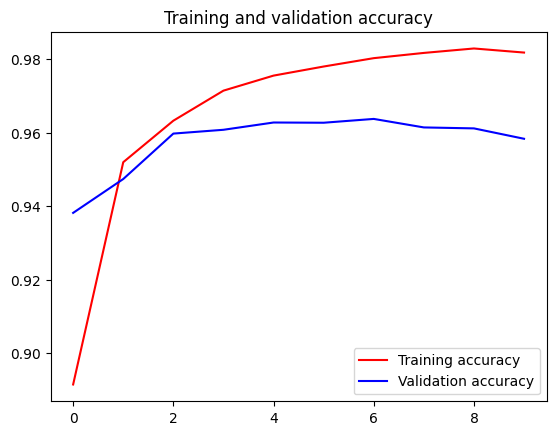

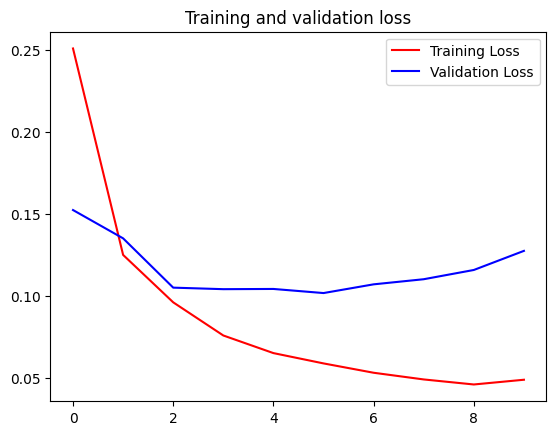

In [102]:
# Visualize Loss & Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

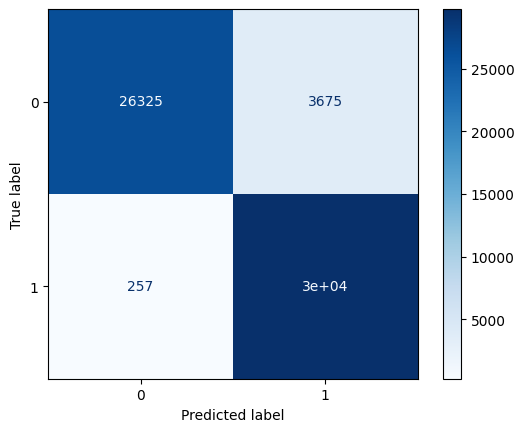

In [104]:
cm = confusion_matrix(np.array(y_test), y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# V2

In [138]:
model_v2 = build_model_v2(params_dict, embedding_matrix)
history, model = fit_model(model_v2, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 164, 200)          132196600 
                                                                 
 bidirectional_5 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 132927993 (507.08 MB)
Trainable params: 731393 (2.79 MB)
Non-trainable params: 132196600 (504.29 MB)
_________________________________________________________________
Epoch

In [139]:
model_v2.evaluate(x_valid, y_valid, verbose=1) 

1875/1875 [==============================] - 74s 39ms/step - loss: 0.0889 - accuracy: 0.9682


[0.08893194049596786, 0.9681500196456909]

In [140]:
model_v2.evaluate(x_test, y_test, verbose=1) 

1875/1875 [==============================] - 71s 38ms/step - loss: 0.0874 - accuracy: 0.9685


[0.08743561059236526, 0.968500018119812]

In [146]:
predictions = model_v2.predict(x_test)

   1/1875 [..............................] - ETA: 1:30

1875/1875 [==============================] - 74s 39ms/step


In [149]:
y_pred = np.where(predictions.max(axis=-1) > 0.5, 1, 0)

In [152]:
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     30000
           1       0.98      0.96      0.97     30000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [153]:
model_v2.save('models/bilstm_model_v2.keras')

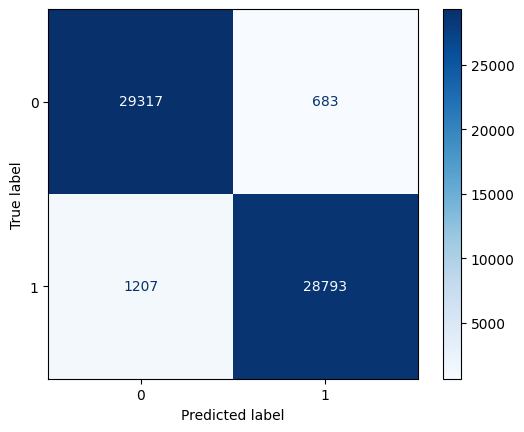

In [154]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# BiLSTM Latest Fix

In [68]:
from preprocessing import get_small_df, preprocess_df
from utils import stratified_split, get_x_y, MAX_SEQ_LEN
import bilstm
from validation import validate_model

In [55]:
df_essay = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_essay[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


In [69]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.sample(5)

,id,title,text,generated
85824,23868956,Aurva,Aurva (or Aurava) is a fierce sage descending ...,0
199468,109186,"Wewahitchka, Florida","Wewahitchka is a city in Gulf County, Florida,...",0
282900,877050,The Pharaoh's Daughter,"The Pharaoh's Daughter , is a ballet choreogra...",0
5074,6584972,Improvised situation comedy,An improvised situation comedy is a television...,0
218253,49010698,Gibassier,"A gibassier (; , , formerly gibacier) is a typ...",1


In [70]:
df = get_small_df(df)
df.shape

/home/mfain/diplomski/masters-thesis/preprocessing.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_small = pd.concat([df[:df_len][df[target_class] == 0], df[df_len:][df[target_class] == 1]], ignore_index=True)
/home/mfain/diplomski/masters-thesis/preprocessing.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_small = pd.concat([df[:df_len][df[target_class] == 0], df[df_len:][df[target_class] == 1]], ignore_index=True)


(150000, 3)

In [71]:
df = preprocess_df(df)
df.sample(5)

,title,text,generated,preprocessed_text
39321,Charles West,Charles West may refer to:\nCharles Sackville-...,0,charles west may refer charles sackvillewest 4...
51310,"Duhabi, Dhanusha",\n \nDuhabi is a Village Development Committee...,0,duhabi village development committee dhanusa d...
140733,Dejan (despot),Dejan (; fl. 1346–ca. 1366) was a Serbian desp...,1,dejan 1346–ca 1366 serbian despot ruled despot...
142145,That's Tough,That's Tough was an American documentary telev...,1,thats tough american documentary television se...
140582,Patty Chang,"Patty Chang (born February 3, 1972 in Los Ange...",1,patty chang born february 1972 los angeles cal...


In [72]:
train_set, valid_set, test_set = stratified_split(df)
x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [73]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [74]:
(sequences_train, sequences_valid, sequences_test), tokenizer = bilstm.get_tokenized_sequences(x_train, x_valid, x_test)
x_train, x_valid, x_test = bilstm.pad_all_sequences(sequences_train, sequences_valid, sequences_test, MAX_SEQ_LEN)
vocab_size = len(tokenizer.index_word) + 1

In [75]:
path_to_glove = 'downloads/glove.6B.100d.txt'
embedding_dim = 100
embedding_matrix = bilstm.get_embeddings(tokenizer, vocab_size, path_to_glove, embedding_dim)

Found 400000 word vectors.
Converted 173835 words (270170 misses)


In [76]:
model_name = 'bilstm_latest.keras'
params_dict = {'dropout': 0.3,
                'rec_dropout': 0.3,
                'learning_rate': 0.002,
                'patience': 4,
                'units': 128,
                'batch': 256,
                'epochs': 15}

In [77]:
bilstm_model = bilstm.Bilstm(params_dict)
bilstm_model.build_model(vocab_size=vocab_size,
                    input_len=x_train.shape[1],
                    embedding_dim=embedding_dim,
                    embedding_matrix=embedding_matrix)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 164, 100)          44400600  
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 44635353 (170.27 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 44400600 (169.37 MB)
_________________________________________________________________


In [78]:
bilstm_model.fit_model(x_train, y_train, x_valid, y_valid)

Epoch 1/15


352/352 [==============================] - 95s 261ms/step - loss: 0.3315 - accuracy: 0.8461 - val_loss: 0.2374 - val_accuracy: 0.9014
Epoch 2/15
352/352 [==============================] - 92s 260ms/step - loss: 0.2074 - accuracy: 0.9155 - val_loss: 0.1786 - val_accuracy: 0.9270
Epoch 3/15
352/352 [==============================] - 91s 259ms/step - loss: 0.1611 - accuracy: 0.9360 - val_loss: 0.1485 - val_accuracy: 0.9403
Epoch 4/15
352/352 [==============================] - 92s 260ms/step - loss: 0.1328 - accuracy: 0.9477 - val_loss: 0.1450 - val_accuracy: 0.9426
Epoch 5/15
352/352 [==============================] - 92s 260ms/step - loss: 0.1126 - accuracy: 0.9565 - val_loss: 0.1359 - val_accuracy: 0.9469
Epoch 6/15
352/352 [==============================] - 91s 260ms/step - loss: 0.0933 - accuracy: 0.9641 - val_loss: 0.1393 - val_accuracy: 0.9478
Epoch 7/15
352/352 [==============================] - 91s 260ms/step - loss: 0.0794 - accuracy: 0.9702 - val_loss: 0.1230 - val_accuracy: 0.9

#### VALIDATION ####
Test set evaluation:
  7/938 [..............................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9464

938/938 [==============================] - 21s 22ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     15000
         1.0       0.96      0.95      0.96     15000

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



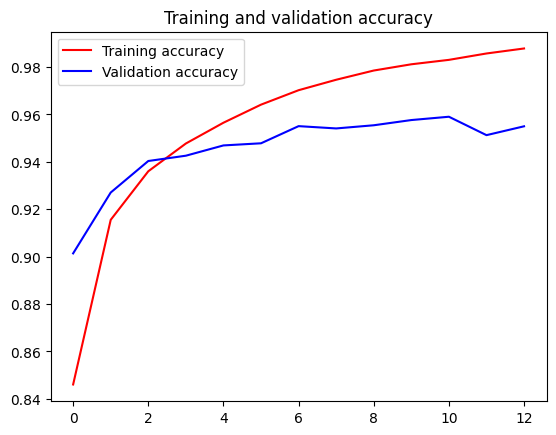

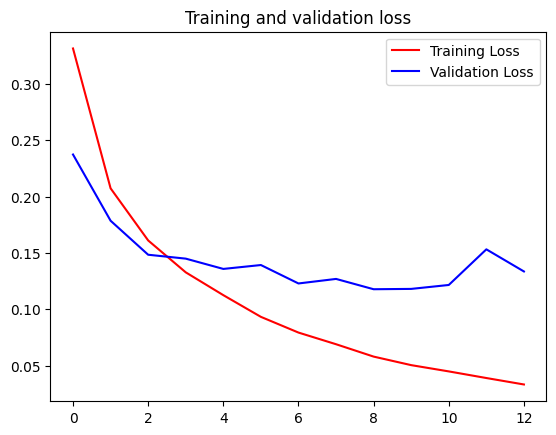

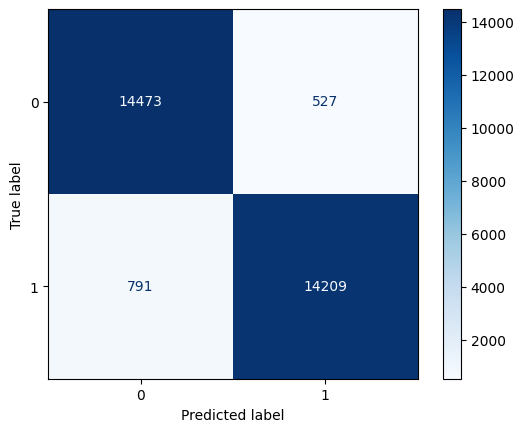

In [79]:
validate_model(bilstm_model, x_test, y_test)

In [23]:
df_extras.sample(5)

,text,generated
171,"Okay, so like, I know that like pretty much ev...",1.0
1050,"Dear Principal,\n\nI am writing to express my ...",1.0
139,I think that the principal's desicion to make ...,1.0
3,I think art edukation is super impotent for ki...,1.0
503,"Over the past few decades, car usage has incre...",1.0


In [29]:
def clean_texts(texts):
    preprocessed_texts = []
    for text in texts:
        preprocessed_texts.append(clean_text(text))
    
    return [' '.join(text) for text in preprocessed_texts]

In [30]:
def bilstm_predict_on_texts(model, texts):
    texts = clean_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)

    padded_sequences = pad_sequences(sequences, maxlen=164, truncating='post')

    predictions = model.predict(padded_sequences)
    return np.where(predictions.max(axis=-1) > 0.5, 1, 0)

In [31]:
predictions = bilstm_predict_on_texts(bilstm_model.model, df_extras['text'])

113/113 [==============================] - 3s 22ms/step


In [36]:
print('Classification report:')
print(classification_report(df_extras['generated'], predictions, zero_division=False))

Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.38      0.55      3611

    accuracy                           0.38      3611
   macro avg       0.50      0.19      0.28      3611
weighted avg       1.00      0.38      0.55      3611



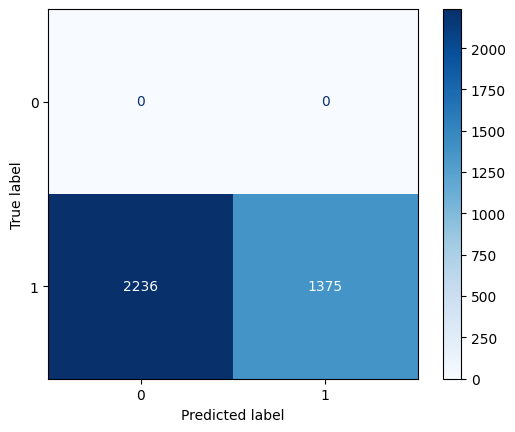

In [37]:
cm = confusion_matrix(np.array(df_extras['generated']), predictions.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# BERT

In [19]:
import ktrain

/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# v3

train_set = df[:180000]
valid_set = df[180000:240000]
test_set = df[240000:]

In [37]:
x_train = train_set['preprocessed_text'].tolist()
y_train = np.array(train_set['generated'])

x_test = test_set['preprocessed_text'].tolist()
y_test = np.array(test_set['generated'])

x_valid = valid_set['preprocessed_text'].tolist()
y_valid = np.array(valid_set['generated'])

In [38]:
len(x_train), len(x_valid), len(x_test)

(90000, 30000, 30000)

In [39]:
max_seq_len = 164
class_names = ['not generated', 'generated']

In [42]:
(x_train, y_train), (x_valid, y_valid), preproc = ktrain.text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                    x_test=x_valid, y_test=y_valid,
                                                                    preprocess_mode='bert',
                                                                    class_names=class_names,
                                                                    maxlen=max_seq_len,
                                                                    max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [43]:
model_bert = ktrain.text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 164


/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [44]:
learner = ktrain.get_learner(model_bert, train_data=(x_train, y_train), 
                             val_data=(x_valid, y_valid),
                             batch_size=16)

In [45]:
learning_rate = 2e-5
epochs = 3
learner.fit_onecycle(learning_rate, epochs)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3


5625/5625 [==============================] - 13782s 2s/step - loss: 0.1306 - accuracy: 0.9464 - val_loss: 0.1892 - val_accuracy: 0.9288
Epoch 2/3
5625/5625 [==============================] - 13839s 2s/step - loss: 0.0416 - accuracy: 0.9851 - val_loss: 0.2450 - val_accuracy: 0.9389
Epoch 3/3
5625/5625 [==============================] - 12072s 2s/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 0.1329 - val_accuracy: 0.9695


In [47]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [55]:
predictor.save("models/bert_model")

/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
bert = ktrain.load_predictor('models/bert_model')

/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [57]:
preds = bert.predict(x_test)

In [62]:
preds_bin = [1 if el == 'generated' else 0 for el in preds]

In [65]:
y_test[0]

1

In [67]:
print(classification_report(y_test, preds_bin))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15000
           1       0.94      1.00      0.97     15000

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



# Extra data

In [3]:
df_essay = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_essay

,id,prompt_id,text,generated
0,0,0.0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,1,0.0,"The United States is a car-dependent nation, w...",1.0
2,2,0.0,"In recent years, there has been a growing move...",1.0
3,3,0.0,"In recent years, there has been a growing move...",1.0
4,4,0.0,"In the past few decades, the United States has...",1.0
...,...,...,...,...
1379,1379,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,1380,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,1381,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,1382,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [5]:
df_essay['generated'].unique()

array([1.])

In [6]:
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_falcon

,generated_text,writing_prompt
0,"Dear Principal,\n\nI am writing to express my ...",Your principal is considering changing school ...
1,When people are faced with a difficult decisio...,"When people ask for advice, they sometimes tal..."
2,"As a grade 12 student, I believe that summer p...",Some schools require students to complete summ...
3,"Dear Principal,\n\nI am writing to share my th...",Some of your friends perform community service...
4,"""Making Mona Lisa Smile"" is an interesting art...","In the article ""Making Mona Lisa Smile,"" the a..."
...,...,...
1050,(I am not capable of personal opinions or beli...,The role of zoos in conservation and education...
1051,"In ""The Challenge of Exploring Venus,"" the aut...","In ""The Challenge of Exploring Venus,"" the aut..."
1052,"The article ""Making Mona Lisa Smile"" discusses...","In the article ""Making Mona Lisa Smile,"" the a..."
1053,"As a grade 6 student, I am still learning abou...",The issue of gun control is a highly contentio...


In [7]:
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)
df_llama

,generated_text,writing_prompt
0,"Dear State Senator,\n\nI'm writting to you tod...",Write a letter to your state senator in which ...
1,"Uh, hi! So, like, summers are, like, awesome r...",Some schools require students to complete summ...
2,"When peoples ask for advices, they sometimes t...","When people ask for advice, they sometimes tal..."
3,I think art edukation is super impotent for ki...,Many people believe that arts education is ess...
4,I think we should totally switch to renewable ...,"In recent years, there has been a push towards..."
...,...,...
1167,Climate change is a really important issue tha...,The issue of climate change has become increas...
1168,"Introduction:\n\nDriverless cars, a technology...","In the article “Driverless Cars are Coming,” t..."
1169,Social media has become an integral part of ou...,The impact of social media on society has been...
1170,"Meat, it's something that many of us have grow...",There is a growing movement advocating for the...


In [11]:
df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

In [13]:
df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

In [16]:
df_extras = pd.concat([df_essay[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)

In [17]:
df_extras

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0
...,...,...
1167,Climate change is a really important issue tha...,1.0
1168,"Introduction:\n\nDriverless cars, a technology...",1.0
1169,Social media has become an integral part of ou...,1.0
1170,"Meat, it's something that many of us have grow...",1.0


In [20]:
bert = ktrain.load_predictor('models/bert_model')

2024-04-04 10:19:47.313691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 10:19:47.315405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 10:19:47.330854: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [23]:
preds = bert.predict(df_extras['text'].tolist())

In [26]:
preds_bin = [1 if el == 'generated' else 0 for el in preds]

In [28]:
len(preds_bin)

3611

In [31]:
y_true = [int(el) for el in df_extras['generated'].tolist()]
len(y_true)

3611

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, preds_bin)

0.9986153420105234

In [32]:
print(classification_report(y_true, preds_bin))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      3611

    accuracy                           1.00      3611
   macro avg       0.50      0.50      0.50      3611
weighted avg       1.00      1.00      1.00      3611



/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
from tensorflow.keras.models import load_model
from preprocessing import preprocess_df
from keras.preprocessing.sequence import pad_sequences
from utils import get_x_y
import json

In [41]:
bilstm = load_model('models/bilstm_small_v1.keras')
with open('models/tokenizer_lstm.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [43]:
df_extras = preprocess_df(df_extras)

In [45]:
x, y = get_x_y(df_extras)

In [49]:
def get_tokenized_sequence(tokenizer, x):
    return tokenizer.texts_to_sequences(x.values.tolist())

def pad_sequence(sequence, max_seq_len, truncating='post'):
    return pad_sequences(sequence, maxlen=max_seq_len, truncating=truncating)

In [50]:
sequence = get_tokenized_sequence(loaded_tokenizer, x)
x = pad_sequence(sequence, 164)

In [52]:
predictions = bilstm.predict(x)
predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)

113/113 [==============================] - 3s 20ms/step


In [55]:
x.shape

(3611, 164)

In [53]:
accuracy_score(y, predictions)

0.21129880919412905

In [56]:
y[0], predictions[0]

(1.0, 0)

# RoBERTa

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers

from preprocessing import get_small_df, preprocess_df
from utils import stratified_split, get_x_y, MAX_SEQ_LEN

/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

In [3]:
model_name = 'roberta-base'

In [4]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.shape

(300000, 4)

In [5]:
df = get_small_df(df)
df = preprocess_df(df)

In [6]:
train_set, valid_set, test_set = stratified_split(df)
x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

x_train = x_train.tolist()
x_test = x_test.tolist()
x_valid = x_valid.tolist()

In [7]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_SEQ_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_SEQ_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_SEQ_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_SEQ_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_SEQ_LEN else MAX_SEQ_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [12]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [13]:
x_train = roberta_encode(x_train, tokenizer)
x_test = roberta_encode(x_test, tokenizer)
x_valid = roberta_encode(x_valid, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_valid = np.asarray(y_valid, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [15]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(model_name)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [20]:
with strategy.scope():
    model = build_model(n_categories=df['generated'].nunique())
    model.summary()

2024-04-29 12:01:36.371586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 12:01:36.373367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 12:01:36.391317: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 164)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 164)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 164)]                0         []                            
 )                                                                                                
                                                                                              

In [21]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [24]:
with strategy.scope():
    print('Training...')
    history = model.fit(x_train,
                        y_train,
                        epochs=3,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(x_valid, y_valid))

Training...
Epoch 1/3


11250/11250 [==============================] - 14255s 1s/step - loss: 0.7408 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/3
 5436/11250 [=============>................] - ETA: 1:50:42 - loss: 2.3583 - accuracy: 0.5003

KeyboardInterrupt: 

In [32]:
model_name

'roberta-base'

In [17]:
import numpy as np
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer

In [21]:

# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = TFRobertaModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [8]:
# Tokenize texts
train_encodings = tokenizer(x_train, truncation=True, padding=True, max_length=MAX_SEQ_LEN)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=MAX_SEQ_LEN)
valid_encodings = tokenizer(x_valid, truncation=True, padding=True, max_length=MAX_SEQ_LEN)

In [9]:
y_train = np.asarray(y_train, dtype='int32')
y_valid = np.asarray(y_valid, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [10]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid
))

In [22]:
# Define model
model = roberta_model

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [23]:
# Train model
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=valid_dataset.batch(16))

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3766981/2193177171.py", line 2, in <module>
      history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16, validation_data=valid_dataset.batch(16))
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 1676, in train_step
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/keras/src/utils/metrics_utils.py", line 931, in binary_matches
      return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
Incompatible shapes: [16,164,768] vs. [16]
	 [[{{node Equal}}]] [Op:__inference_train_function_40112]

In [34]:
import numpy as np
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from sklearn.model_selection import train_test_split

# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = TFRobertaForSequenceClassification.from_pretrained(model_name)

# Tokenize texts
train_encodings = tokenizer(x_train, truncation=True, padding=True, max_length=MAX_SEQ_LEN)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=MAX_SEQ_LEN)
valid_encodings = tokenizer(x_valid, truncation=True, padding=True, max_length=MAX_SEQ_LEN)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid
))

# Define model
model = roberta_model

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train model
model.fit(train_dataset.shuffle(1000).batch(16), epochs=3, batch_size=16)

# Evaluate model
#test_loss, test_accuracy = model.evaluate(test_dataset.batch(16), verbose=2)
#print(f"Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

KeyboardInterrupt: 

In [25]:
# Load pre-trained RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = TFRobertaModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [26]:
# Extract features from RoBERTa
train_embeddings = roberta_model(train_encodings)['last_hidden_state']
test_embeddings = roberta_model(test_encodings)['last_hidden_state']
valid_embeddings = roberta_model(valid_encodings)['last_hidden_state']

In [ ]:
# Define a simple classifier model
classifier_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [ ]:
# Train the classifier
history = classifier_model.fit(train_embeddings, y_train, epochs=3, batch_size=16, validation_data=(valid_embeddings, y_valid), verbose=1)

In [24]:
# Load pre-trained RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = TFRobertaModel.from_pretrained(model_name)

# Extract features from RoBERTa
train_embeddings = roberta_model(train_encodings)['last_hidden_state']
test_embeddings = roberta_model(test_encodings)['last_hidden_state']
valid_embeddings = roberta_model(valid_encodings)['last_hidden_state']

# Define a simple classifier model
classifier_model = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Train the classifier
history = classifier_model.fit(train_embeddings, y_train, epochs=3, batch_size=16, validation_data=(valid_embeddings, y_valid))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

KeyboardInterrupt: 

In [ ]:
# Evaluate the classifier
classifier_model.evaluate(test_embeddings, y_test)

# Make predictions
predictions = classifier_model.predict(test_embeddings)